# Plot filtered tf corrected external data
Compare external data ps with SAT ps.
Assuming spectra loaded from disk already beam corrected.

In [1]:
import matplotlib.pyplot as plt
from pixell import reproject, enmap, utils, enplot
import numpy as np
import healpy as hp
import pymaster as nmt
from scipy.optimize import curve_fit

In [2]:
%matplotlib inline

#### Parameters

In [ ]:
dir_cells = '/scratch/gpfs/SIMONSOBS/users/ar3186/external_data/filtered_data/planck/npipe6v20_A_B/satp3/f100/soopercool_outputs/cells_beam_corrected/'
data0_label = 'SATp3_f090_south_science'
data1_label = 'planck_f100_filtered_SATp3_f090_south_science'
exp_pairs = [[f'{data0_label}',f'{data0_label}'], [f'{data0_label}',f'{data1_label}'], [f'{data1_label}',f'{data1_label}']]

In [21]:
binning_file = '/scratch/gpfs/SIMONSOBS/sat-iso/transfer_function/soopercool_inputs/binning_car_lmax2160_deltal15_large_first_bin.npz'
fiducial_cmb = '/scratch/gpfs/SIMONSOBS/users/ar3186/common/camb_spectra/cls_planck_TT_EE_BB_TE.fits'

In [22]:
mode = 'EE'
imode_cmb = 1 # position of the selected mode in the cmb file
lmax_plot = 600
colors = ['blue', 'orange', 'green']
type = 'cross'

In [23]:
# pix win to correct for
lmax_pix_win = 10000
pix_win_data0 = np.ones(lmax_pix_win)
pix_win_data1 = hp.pixwin(2048, pol=True, lmax=lmax_pix_win)[1]  # pix win in planck data

#### Get pix win functions to correct for

In [24]:
binning_edges = np.load(binning_file)
bin_centers_int = np.array(binning_edges['bin_center'], dtype=int) # NOTE: this is exact only if bin centers are all integer values
pix_win_data0_centers = pix_win_data0[bin_centers_int]
pix_win_data1_centers = pix_win_data1[bin_centers_int]

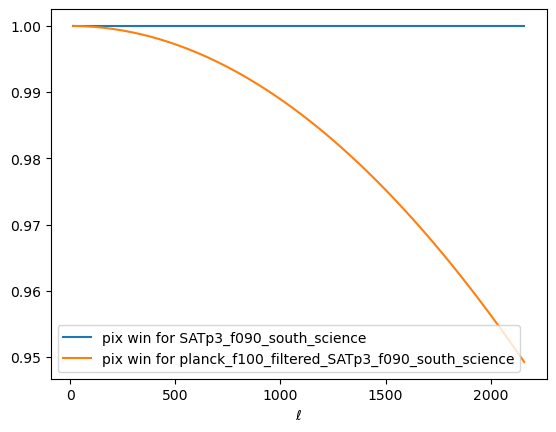

In [25]:
plt.plot(bin_centers_int, pix_win_data0_centers, label=f'pix win for {data0_label}')
plt.plot(bin_centers_int, pix_win_data1_centers, label=f'pix win for {data1_label}')
plt.xlabel(r'$\ell$')
plt.legend()

In [26]:
pix_win_all = [pix_win_data0_centers**2, pix_win_data0_centers*pix_win_data1_centers, pix_win_data1_centers**2]

#### Get fiducial LCDM CMB

In [27]:
nmt_bins = nmt.NmtBin.from_edges(binning_edges["bin_low"],
                                     binning_edges["bin_high"] + 1)
lmax_bins = nmt_bins.get_ell_max(nmt_bins.get_n_bands() - 1)
lb = nmt_bins.get_effective_ells()
lb_msk = lb < lmax_plot + 10

In [28]:
cmb_cl = hp.read_cl(fiducial_cmb)[imode_cmb, :lmax_bins+1]
cmb_clb = nmt_bins.bin_cell(cmb_cl)[lb_msk]

#### Get cls external data before filtering

In [29]:
### geometry template 
# (used to reproject the initial maps in the same geometry as the filtered coadded maps)
path_iso_geometry_template = '/home/ar3186/pwg-scripts/iso-sat-review/mapmaking/band_car_fejer1_5arcmin.fits'

In [30]:
### iso-sat analysis mask
# (used in soopercool to compute the TF corrected filtered coadded data ps)
path_iso_analysis_mask = '/scratch/gpfs/SIMONSOBS/sat-iso/transfer_function/satp3/south/soopercool_outputs/science/masks/analysis_mask.fits'

In [31]:
### Parameters for initial external data
dir_initial_data = '/scratch/gpfs/SIMONSOBS/users/ar3186/external_data/data'
exp = 'planck'
maps_type_A = 'npipe6v20A'
maps_type_B = 'npipe6v20B'
band = '100'
nside = 512
res = 1.0
lmax = 2160

In [32]:
## Maps initial external data full sky in hp
path_maps_initial_data_hp_A = f'{dir_initial_data}/{exp}/maps/{maps_type_A}/{exp}_hp_{band}_bundle0_nside{nside}_coords_c.fits'
path_maps_initial_data_hp_B = f'{dir_initial_data}/{exp}/maps/{maps_type_B}/{exp}_hp_{band}_bundle1_nside{nside}_coords_c.fits'
maps_initial_data_hp_A = hp.read_map(path_maps_initial_data_hp_A, field=(0,1,2))
maps_initial_data_hp_B = hp.read_map(path_maps_initial_data_hp_B, field=(0,1,2))

In [33]:
## Maps initial external data partial sky (--> geometry of the iso-sat analysis: band and 5amin) in car
# (we always use this geometry everywhere)

# get the geometry of the template
shape, wcs = enmap.read_map_geometry(path_iso_geometry_template)

# reproject the initial hp map to car with the geometry from the iso template
maps_initial_data_car_isogeo_A = reproject.healpix2map(maps_initial_data_hp_A, shape=shape, wcs=wcs)
maps_initial_data_car_isogeo_B = reproject.healpix2map(maps_initial_data_hp_B, shape=shape, wcs=wcs)

In [34]:
## Maps initial external data partial sky (--> iso-sat analysis mask) in car

# load iso-sat analysis mask
analysis_mask_car = enmap.read_map(path_iso_analysis_mask)

In [35]:
# compute ps for initial external data in car and with the iso-sat geometry
field_pol_A = nmt.NmtField(mask=analysis_mask_car, maps=[maps_initial_data_car_isogeo_A[1], maps_initial_data_car_isogeo_A[2]], wcs=wcs, lmax=lmax, lmax_mask=lmax)
field_pol_B = nmt.NmtField(mask=analysis_mask_car, maps=[maps_initial_data_car_isogeo_B[1], maps_initial_data_car_isogeo_B[2]], wcs=wcs, lmax=lmax, lmax_mask=lmax)
cls_initial_pol = (nmt.compute_full_master(field_pol_A, field_pol_B, nmt_bins))

#### Plot all

(1e-06, 1.0)

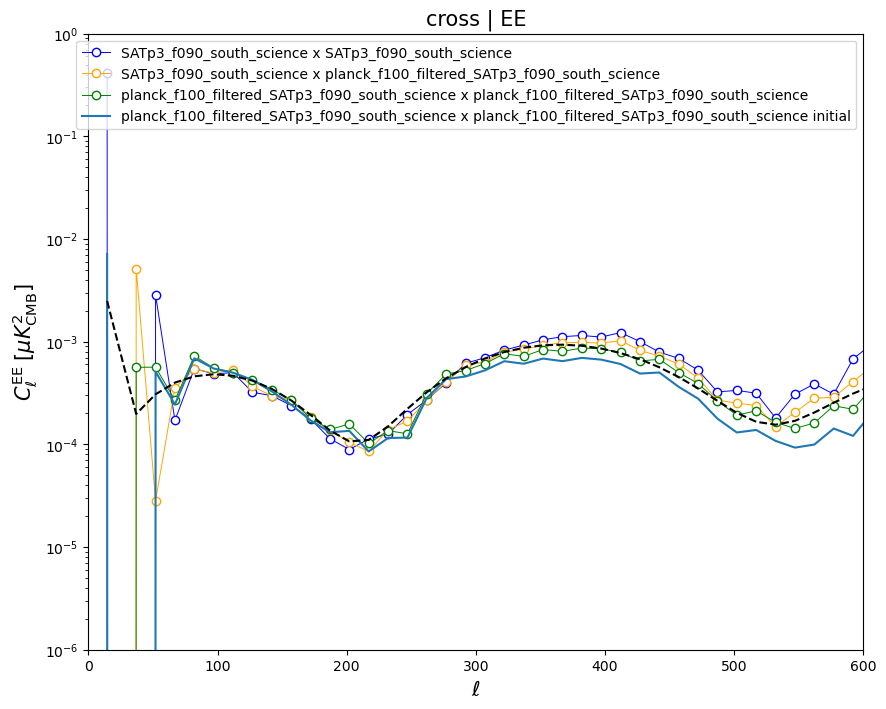

In [36]:
plt.figure(figsize=(10, 8))
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$C_\ell^\mathrm{%s} \; [\mu K_\mathrm{CMB}^2]$" % mode,
            fontsize=15)

# for type in ['cross']:  #['cross', 'auto', 'noise']:
for iep, ep in enumerate(exp_pairs):
    path_cls_filtered_coadded_tf = f'decoupled_{type}_pcls_{ep[0]}_x_{ep[1]}.npz'
    cls_filtered_coadded_tf = np.load(dir_cells + path_cls_filtered_coadded_tf)


    plt.plot(cls_filtered_coadded_tf['lb'], cls_filtered_coadded_tf[mode]/pix_win_all[iep], label = f'{ep[0]} x {ep[1]}', lw=0.7, mfc="w", marker="o", c=colors[iep])

plt.plot(nmt_bins.get_effective_ells(), cls_initial_pol[0]*1e12, label=f'{data1_label} x {data1_label} initial')

plt.plot(cls_filtered_coadded_tf['lb'][:len(cmb_clb)], cmb_clb, c="k", ls="--")

plt.legend(fontsize=10)
plt.title(f'{type} | {mode}', fontsize=15)
# plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 600) #lmax)
plt.ylim(1e-6, 1e0)